In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from rootpy.io import root_open
import ROOT
ROOT.gROOT.SetBatch(True)

Welcome to JupyROOT 6.12/07


In [3]:
infile_r = None  # input file handle

def load_pgun():
  global infile_r
  #infile = '../test7/ntuple_SingleMuon_Endcap_2GeV_add.5.root'
  infile = '../test7/ntuple_SingleMuon_Displaced_FlatPhi_2GeV_add.5.root'
  #if use_condor:
  #  infile = 'root://cmsio5.rc.ufl.edu//store/user/jiafulow/L1MuonTrigger/P2_10_1_5/SingleMuon_Toy_2GeV/'+infile
  infile_r = root_open(infile)
  tree = infile_r.ntupler.tree
  #tree = TreeChain('ntupler/tree', [infile])
  print('[INFO] Opening file: %s' % infile)

  # Define collection
  tree.define_collection(name='hits', prefix='vh_', size='vh_size')
  tree.define_collection(name='tracks', prefix='vt_', size='vt_size')
  tree.define_collection(name='particles', prefix='vp_', size='vp_size')
  #tree.define_collection(name='evt_info', prefix='ve_', size='ve_size')
  return tree

def load_pgun_omtf():
  global infile_r
  infile = '../test7/ntuple_SingleMuon_Overlap_3GeV_add.5.root'
  infile_r = root_open(infile)
  tree = infile_r.ntupler.tree
  #tree = TreeChain('ntupler/tree', [infile])
  print('[INFO] Opening file: %s' % infile)

  # Define collection
  tree.define_collection(name='hits', prefix='vh_', size='vh_size')
  tree.define_collection(name='tracks', prefix='vt_', size='vt_size')
  tree.define_collection(name='particles', prefix='vp_', size='vp_size')
  #tree.define_collection(name='evt_info', prefix='ve_', size='ve_size')
  return tree

In [4]:
maxEvents = 400000
#maxEvents = 10000

kDT, kCSC, kRPC, kGEM, kME0 = 0, 1, 2, 3, 4

nlayers = 16  # 5 (CSC) + 4 (RPC) + 3 (GEM) + 4 (DT)

# Decide EMTF hit layer number
class EMTFLayer(object):
  def __init__(self):
    lut = np.zeros((5,5,5), dtype=np.int32) - 99  # (type, station, ring) -> layer
    lut[1,1,4] = 0  # ME1/1a
    lut[1,1,1] = 0  # ME1/1b
    lut[1,1,2] = 1  # ME1/2
    lut[1,1,3] = 1  # ME1/3
    lut[1,2,1] = 2  # ME2/1
    lut[1,2,2] = 2  # ME2/2
    lut[1,3,1] = 3  # ME3/1
    lut[1,3,2] = 3  # ME3/2
    lut[1,4,1] = 4  # ME4/1
    lut[1,4,2] = 4  # ME4/2
    lut[2,1,2] = 5  # RE1/2
    lut[2,1,3] = 5  # RE1/3
    lut[2,2,2] = 6  # RE2/2
    lut[2,2,3] = 6  # RE2/3
    lut[2,3,1] = 7  # RE3/1
    lut[2,3,2] = 7  # RE3/2
    lut[2,3,3] = 7  # RE3/3
    lut[2,4,1] = 8  # RE4/1
    lut[2,4,2] = 8  # RE4/2
    lut[2,4,3] = 8  # RE4/3
    lut[3,1,1] = 9  # GE1/1
    lut[3,2,1] = 10 # GE2/1
    lut[4,1,1] = 11 # ME0
    lut[0,1,1] = 12 # MB1
    lut[0,2,1] = 13 # MB2
    lut[0,3,1] = 14 # MB3
    lut[0,4,1] = 15 # MB4
    self.lut = lut

  def __call__(self, hit):
    index = (hit.type, hit.station, hit.ring)
    entry = self.lut[index]
    return entry

find_emtf_layer = EMTFLayer()

def find_endsec(endcap, sector):
  endsec = (sector - 1) if endcap == 1 else (sector - 1 + 6)
  return endsec

def calculate_d0(invPt, phi, xv, yv, B=3.811):
  _invPt = np.asarray(invPt, dtype=np.float64)   # needs double precision
  _invPt = np.where(np.abs(_invPt) < 1./10000, np.sign(_invPt+1e-15) * 1./10000, _invPt)
  _R = -1.0 / (0.003 * 3.811 * _invPt)           # R = -pT/(0.003 q B)  [cm]
  _xc = xv - (_R * np.sin(phi))                  # xc = xv - R sin(phi)
  _yc = yv + (_R * np.cos(phi))                  # yc = yv + R cos(phi)
  _d0 = _R - (np.sign(_R) * np.hypot(_xc, _yc))  # d0 = R - sign(R) * sqrt(xc^2 + yc^2)
  return _d0.astype(np.float32, casting='same_kind')

# Decide EMTF legit hit
def is_emtf_legit_hit(hit):
  def check_bx(hit):
    if hit.type == kCSC:
      return hit.bx in (-1,0)
    elif hit.type == kDT:
      return hit.bx in (-1,0)
    else:
      return hit.bx == 0
  def check_emtf_phi(hit):
    if hit.type == kME0:
      return hit.emtf_phi > 0
    elif hit.type == kDT:
      return hit.emtf_phi > 0
    else:
      return True
  #return check_bx(hit) and check_emtf_phi(hit)
  return check_emtf_phi(hit)

In [5]:
class Collector(object):
  def __init__(self, select_fn_1, select_fn_2):
    self.select_fn_1 = select_fn_1
    self.select_fn_2 = select_fn_2

  def run(self, hits):
    selected_hits_1 = np.empty((12,), dtype=np.object)
    selected_hits_2 = np.empty((12,), dtype=np.object)
    for ind in np.ndindex(selected_hits_1.shape):
      selected_hits_1[ind] = []
      selected_hits_2[ind] = []

    # Loop over hits
    for ihit, hit in enumerate(hits):
      hit.endsec = find_endsec(hit.endcap, hit.sector)
      hit.lay = find_emtf_layer(hit)
      assert(hit.lay != -99)

      if self.select_fn_1(hit):
        selected_hits_1[hit.endsec].append(ihit)
      if self.select_fn_2(hit):
        selected_hits_2[hit.endsec].append(ihit)

    # Loop over sectors
    dphis = []
    dthetas = []

    for endsec in xrange(12):
      hit_1 = None
      hit_2 = None

      if selected_hits_1[endsec]:
        ihit = np.random.choice(selected_hits_1[endsec])
        hit_1 = hits[ihit]

      if selected_hits_2[endsec]:
        ihit = np.random.choice(selected_hits_2[endsec])
        hit_2 = hits[ihit]

      if hit_1 is not None and hit_2 is not None:
        dphi = hit_1.emtf_phi - hit_2.emtf_phi
        dphis.append(dphi)
        dtheta = hit_1.emtf_theta - hit_2.emtf_theta
        dthetas.append(dtheta)
    
    # Return one dphi value
    if dphis:
      dphi = np.random.choice(dphis)
      dtheta = np.random.choice(dthetas)
    else:
      dphi = np.nan
      dtheta = np.nan
    return dphi, dtheta

In [6]:
# Main analysis

def analysis(verbose=1, omtf=False):
  if omtf:
    tree = load_pgun_omtf()
  else:
    tree = load_pgun()

  select_fn_11 = lambda hit: (hit.type == kCSC and hit.station == 1 and (hit.ring == 1 or hit.ring == 4) and hit.neighbor == 0)
  select_fn_12 = lambda hit: (hit.type == kCSC and hit.station == 1 and (hit.ring == 2 or hit.ring == 3) and hit.neighbor == 0)
  select_fn_2 = lambda hit: (hit.type == kCSC and hit.station == 2 and hit.neighbor == 0)
  select_fn_3 = lambda hit: (hit.type == kCSC and hit.station == 3 and hit.neighbor == 0)
  select_fn_4 = lambda hit: (hit.type == kCSC and hit.station == 4 and hit.neighbor == 0)

  collect_1 = Collector(select_fn_11, select_fn_2)
  collect_2 = Collector(select_fn_11, select_fn_3)
  collect_3 = Collector(select_fn_11, select_fn_4)
  collect_4 = Collector(select_fn_12, select_fn_2)
  collect_5 = Collector(select_fn_12, select_fn_3)
  collect_6 = Collector(select_fn_12, select_fn_4)
  collect_7 = Collector(select_fn_2, select_fn_3)
  collect_8 = Collector(select_fn_2, select_fn_4)
  collect_9 = Collector(select_fn_3, select_fn_4)

  out_part, out_dphis, out_dthetas = [], [], []

  # Loop over events
  for ievt, evt in enumerate(tree):
    if maxEvents != -1 and ievt == maxEvents:
      break

    if verbose and (ievt % 10000 == 0):  print("Processing event: {0}".format(ievt))

    # Skip events with very few hits
    if not len(evt.hits) >= 2:
      continue

    # Skip events without ME1 hits
    has_ME1 = False
    for ihit, hit in enumerate(evt.hits):
      if hit.type == kCSC and hit.station == 1:
        has_ME1 = True
        break
      elif hit.type == kME0 and hit.station == 1:
        has_ME1 = True
        break
      elif hit.type == kDT and (hit.station == 1 or hit.station == 2):
        has_ME1 = True
        break
    #if not has_ME1:
    #  continue

    part = evt.particles[0]  # particle gun
    part.invpt = np.true_divide(part.q, part.pt)
    part.d0 = calculate_d0(part.invpt, part.phi, part.vx, part.vy)

    dphi_1, dtheta_1 = collect_1.run(evt.hits)
    dphi_2, dtheta_2 = collect_2.run(evt.hits)
    dphi_3, dtheta_3 = collect_3.run(evt.hits)
    dphi_4, dtheta_4 = collect_4.run(evt.hits)
    dphi_5, dtheta_5 = collect_5.run(evt.hits)
    dphi_6, dtheta_6 = collect_6.run(evt.hits)
    dphi_7, dtheta_7 = collect_7.run(evt.hits)
    dphi_8, dtheta_8 = collect_8.run(evt.hits)
    dphi_9, dtheta_9 = collect_9.run(evt.hits)
    dphis = (dphi_1, dphi_2, dphi_3, dphi_4, dphi_5, dphi_6, dphi_7, dphi_8, dphi_9)
    dthetas = (dtheta_1, dtheta_2, dtheta_3, dtheta_4, dtheta_5, dtheta_6, dtheta_7, dtheta_8, dtheta_9)

    # Output
    out_part.append((part.invpt, part.eta, part.phi, part.d0))
    out_dphis.append(dphis)
    out_dthetas.append(dthetas)
    continue  # end loop over events

  if verbose: print "DONE"
  return np.asarray(out_part, dtype=np.float32), np.asarray(out_dphis, dtype=np.float32), np.asarray(out_dthetas, dtype=np.float32)

In [7]:
# Load

outfile = 'x_phi_displ2_out.0.npz'
with np.load(outfile) as loaded:
  out_part = loaded['out_part']
  out_dphis = loaded['out_dphis']
  out_dthetas = loaded['out_dthetas']

print out_part.shape, out_dphis.shape, out_dthetas.shape, out_part.dtype, out_dphis.shape, out_dthetas.shape

(318168, 4) (318168, 9) (318168, 9) float32 (318168, 9) (318168, 9)


In [8]:
# Styling
plt.style.use('tdrstyle.mplstyle')

In [9]:
import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

In [10]:
from scipy.optimize import curve_fit

def gaus(x,a,mu,sig):
  return a*np.exp(-0.5*np.square((x-mu)/sig))

def fit_gaus(hist, edges, mu=0., sig=1.):
  hist = hist.astype('float64')
  edges = edges.astype('float64')
  xdata = (edges[1:] + edges[:-1])/2
  ydata = hist
  popt, pcov = curve_fit(gaus, xdata, ydata, p0=[np.max(hist),mu,sig])
  if not np.isfinite(pcov).all():
    raise Exception('Fit has failed to converge.')
  return popt

In [11]:
convert_to_rad = lambda x: x * np.deg2rad(1./60)

part_pt = out_part[:, 0]
part_q = np.sign(out_part[:, 0])
part_eta = out_part[:, 1]
part_phi = out_part[:, 2]
part_d0 = out_part[:, 3]

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-numpy/1.15.1/lib/python2.7/site-packages/numpy/lib/histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-numpy/1.15.1/lib/python2.7/site-packages/numpy/lib/histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-matplotlib/2.2.3-ikaegh/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


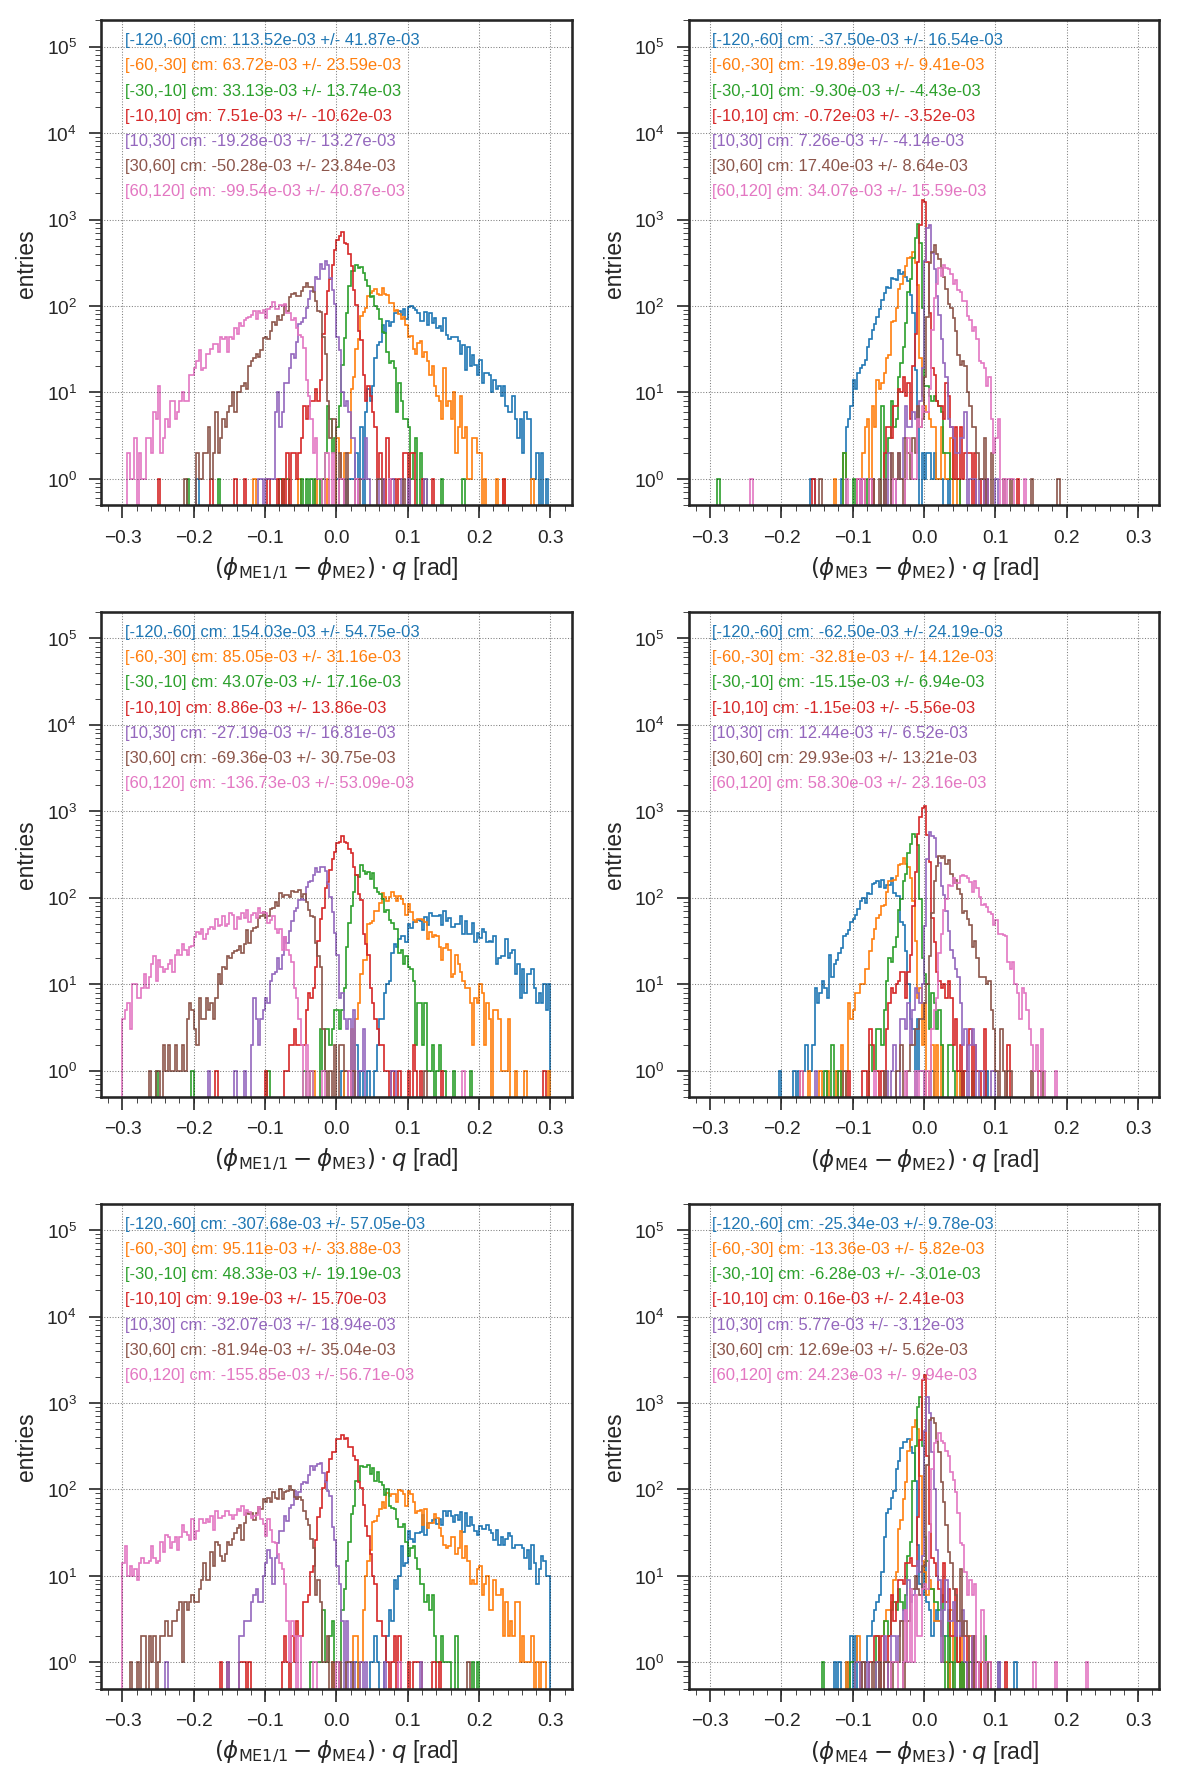

In [12]:
# Plot deflection angles for |eta| > 1.6, pT > 20 GeV
fig, axs = plt.subplots(3, 2, figsize=(8,12), tight_layout=True)

#pt_slices = [2, 3, 5, 10, 20, 50]

d0_slices = [-120, -60, -30, -10, 10, 30, 60, 120 ]

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']

labels = [
  r'$(\phi_{\mathrm{ME1/1}} - \phi_{\mathrm{ME2}}) \cdot q$ [rad]',
  r'$(\phi_{\mathrm{ME1/1}} - \phi_{\mathrm{ME3}}) \cdot q$ [rad]',
  r'$(\phi_{\mathrm{ME1/1}} - \phi_{\mathrm{ME4}}) \cdot q$ [rad]',
  r'$(\phi_{\mathrm{ME3}} - \phi_{\mathrm{ME2}}) \cdot q$ [rad]',
  r'$(\phi_{\mathrm{ME4}} - \phi_{\mathrm{ME2}}) \cdot q$ [rad]',
  r'$(\phi_{\mathrm{ME4}} - \phi_{\mathrm{ME3}}) \cdot q$ [rad]',
]

for i in xrange(6):
  for j in xrange(len(d0_slices)-1):
    label = labels[i]
    d0_low = d0_slices[j]
    d0_high = d0_slices[j+1]
    color = colors[j]

    discr_pt_cut_high = 14.
    sel = (d0_low <= (part_d0 * part_q)) & \
          ((part_d0 * part_q) <= d0_high) & \
          (np.abs(1.0/part_pt) > discr_pt_cut_high) & (np.abs(part_eta) > 1.6)

    if i == 0:
      dphi = convert_to_rad(out_dphis[:, 0][sel])
      dphi *= part_q[sel]
    elif i == 1:
      dphi = convert_to_rad(out_dphis[:, 1][sel])
      dphi *= part_q[sel]
    elif i == 2:
      dphi = convert_to_rad(out_dphis[:, 2][sel])
      dphi *= part_q[sel]
    elif i == 3:
      dphi = -convert_to_rad(out_dphis[:, 6][sel])
      dphi *= part_q[sel]
    elif i == 4:
      dphi = -convert_to_rad(out_dphis[:, 7][sel])
      dphi *= part_q[sel]
    elif i == 5:
      dphi = -convert_to_rad(out_dphis[:, 8][sel])
      dphi *= part_q[sel]
    
    ax = axs[i%3,i/3]
    hist, edges, _ = ax.hist(dphi, bins=180, range=(-0.3,0.3), histtype='step', color=color, linewidth=0.8)
    popt = fit_gaus(hist, edges, mu=0, sig=0.1)
    ax.text(0.05, 0.95-0.052*j, '[{0:d},{1:d}] cm: {2:.2f}e-03 +/- {3:.2f}e-03'.format(d0_low, d0_high, popt[1]*1e3, popt[2]*1e3), color=color, fontsize=8, transform=ax.transAxes)
    ax.set_xlabel(label)
    ax.set_ylabel(r'entries')
    ax.set_yscale('log')
    ax.set_ylim(0.5, 2e5)
    
plt.show()

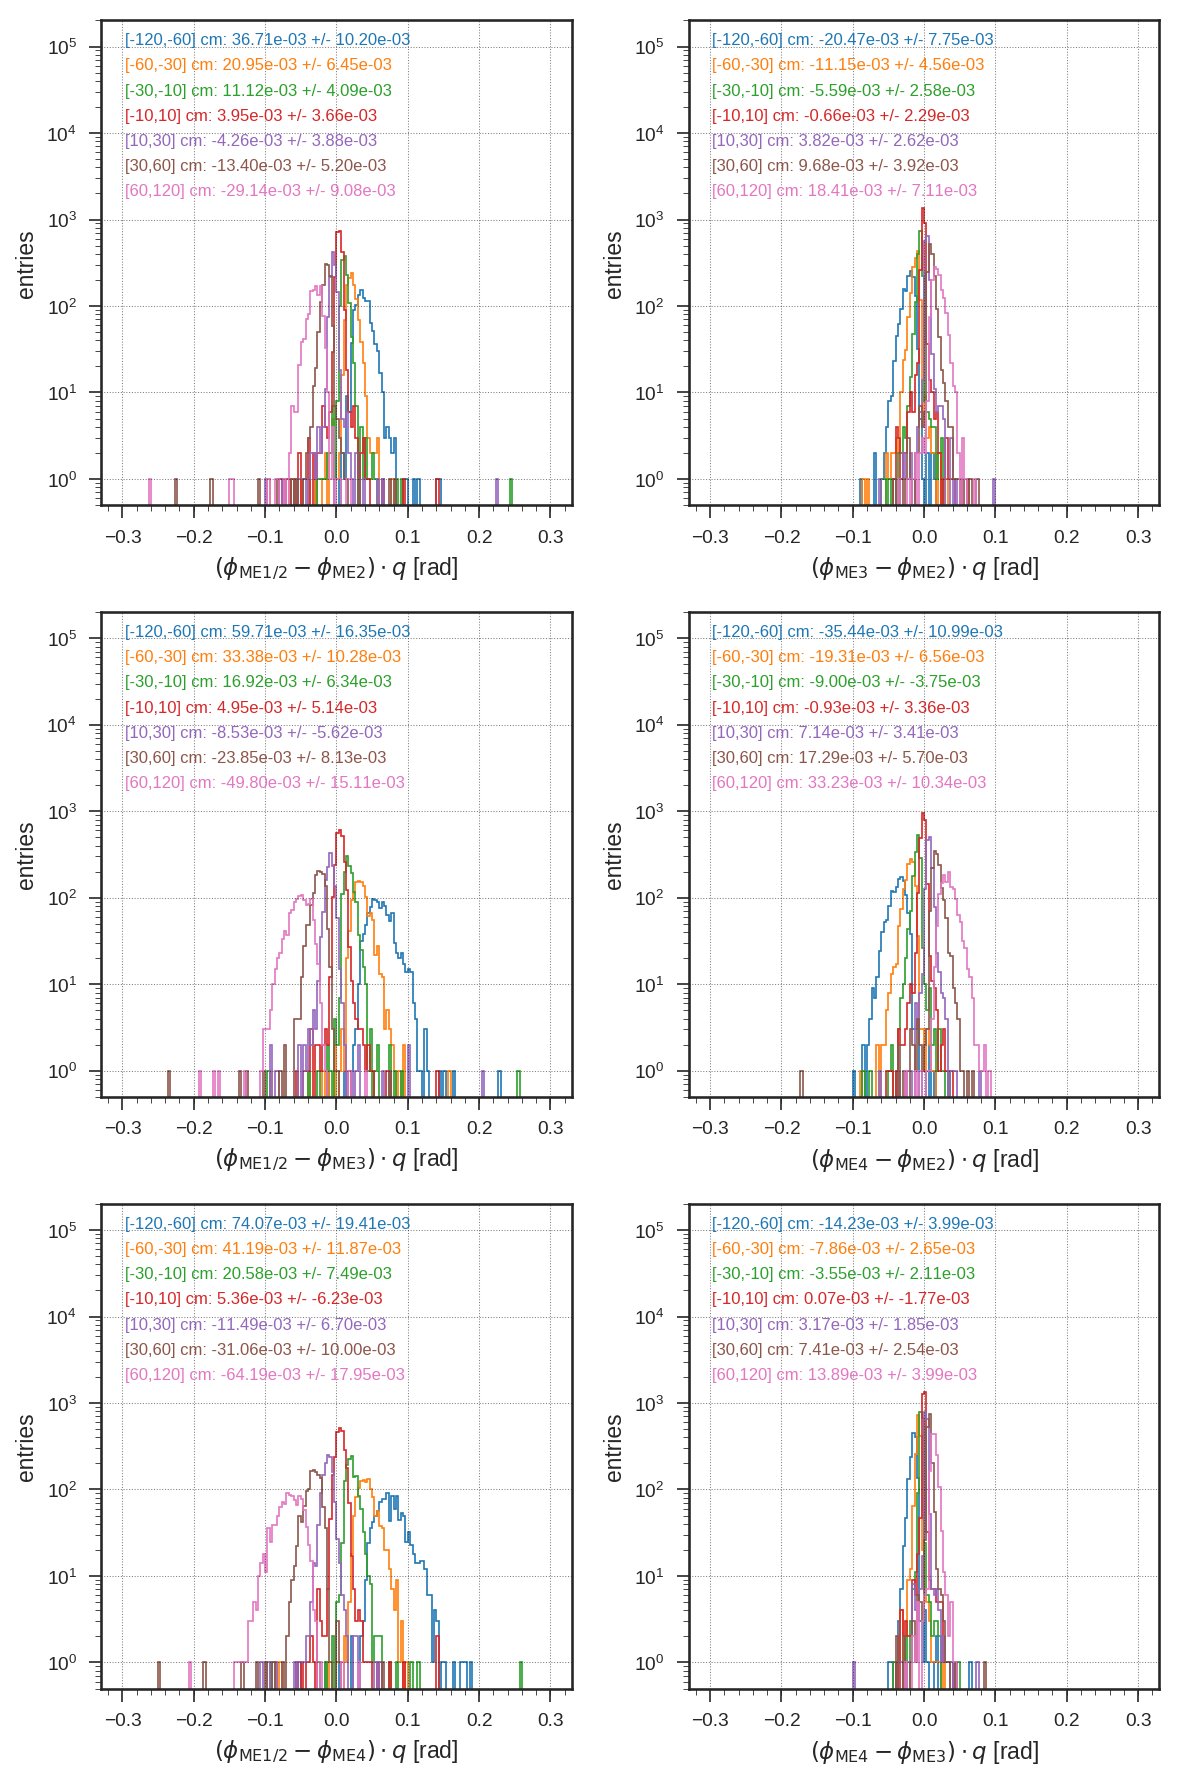

In [13]:
# Plot deflection angles for |eta| < 1.6, pT > 20 GeV
fig, axs = plt.subplots(3, 2, figsize=(8,12), tight_layout=True)

#pt_slices = [2, 3, 5, 10, 20, 50]

d0_slices = [-120, -60, -30, -10, 10, 30, 60, 120 ]

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']

labels = [
  r'$(\phi_{\mathrm{ME1/2}} - \phi_{\mathrm{ME2}}) \cdot q$ [rad]',
  r'$(\phi_{\mathrm{ME1/2}} - \phi_{\mathrm{ME3}}) \cdot q$ [rad]',
  r'$(\phi_{\mathrm{ME1/2}} - \phi_{\mathrm{ME4}}) \cdot q$ [rad]',
  r'$(\phi_{\mathrm{ME3}} - \phi_{\mathrm{ME2}}) \cdot q$ [rad]',
  r'$(\phi_{\mathrm{ME4}} - \phi_{\mathrm{ME2}}) \cdot q$ [rad]',
  r'$(\phi_{\mathrm{ME4}} - \phi_{\mathrm{ME3}}) \cdot q$ [rad]',
]

for i in xrange(6):
  for j in xrange(len(d0_slices)-1):
    label = labels[i]
    d0_low = d0_slices[j]
    d0_high = d0_slices[j+1]
    color = colors[j]

    discr_pt_cut_high = 14.
    sel = (d0_low <= (part_d0 * part_q)) & \
          ((part_d0 * part_q) <= d0_high) & \
          (np.abs(1.0/part_pt) > discr_pt_cut_high) & (np.abs(part_eta) < 1.6)

    if i == 0:
      dphi = convert_to_rad(out_dphis[:, 3][sel])
      dphi *= part_q[sel]
    elif i == 1:
      dphi = convert_to_rad(out_dphis[:, 4][sel])
      dphi *= part_q[sel]
    elif i == 2:
      dphi = convert_to_rad(out_dphis[:, 5][sel])
      dphi *= part_q[sel]
    elif i == 3:
      dphi = -convert_to_rad(out_dphis[:, 6][sel])
      dphi *= part_q[sel]
    elif i == 4:
      dphi = -convert_to_rad(out_dphis[:, 7][sel])
      dphi *= part_q[sel]
    elif i == 5:
      dphi = -convert_to_rad(out_dphis[:, 8][sel])
      dphi *= part_q[sel]
    
    ax = axs[i%3,i/3]
    hist, edges, _ = ax.hist(dphi, bins=180, range=(-0.3,0.3), histtype='step', color=color, linewidth=0.8)
    popt = fit_gaus(hist, edges, mu=0, sig=0.1)
    ax.text(0.05, 0.95-0.052*j, '[{0:d},{1:d}] cm: {2:.2f}e-03 +/- {3:.2f}e-03'.format(d0_low, d0_high, popt[1]*1e3, popt[2]*1e3), color=color, fontsize=8, transform=ax.transAxes)
    ax.set_xlabel(label)
    ax.set_ylabel(r'entries')
    ax.set_yscale('log')
    ax.set_ylim(0.5, 2e5)
    
plt.show()